In [86]:
from transformers import pipeline
from nltk import sent_tokenize
import nltk
import torch
from glob import glob
import pandas as pd
import re
import numpy as np

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/shiven/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Load Model

In [3]:
model_name="facebook/bart-large-mnli"
device = 0 if torch.cuda.is_available() else 'cpu'

In [4]:
def load_model(device):
    theme_classifier = pipeline(
        "zero-shot-classification",
        model=model_name,
        device=device,
    )
    return theme_classifier

In [5]:
theme_classifier = load_model(device)

/Users/shiven/anaconda3/envs/gradio_env/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [6]:
theme_list = ["friendship","hope","sacrifice","battle","self development","betrayal","love","dialogue"]

In [9]:
theme_classifier(
    "I gave him a right hook then a left jab",
    theme_list,
    multi_label=True
)

{'sequence': 'I gave him a right hook then a left jab',
 'labels': ['battle',
  'self development',
  'hope',
  'sacrifice',
  'dialogue',
  'betrayal',
  'love',
  'friendship'],
 'scores': [0.9121254682540894,
  0.4750019907951355,
  0.08781785517930984,
  0.04500039294362068,
  0.020132992416620255,
  0.012040446512401104,
  0.004292389843612909,
  0.002817214699462056]}

# Load Dataset

In [59]:
files = glob('../data/Subtitles/*.ass')

In [ ]:
#doing this because for some reason glob wasnt giving a sorted output
def extract_season_episode(file_path):
    match = re.search(r"Season (\d+) - (\d+)", file_path)
    if match:
        season = int(match.group(1))
        episode = int(match.group(2))
        return (season, episode)
    return (0, 0)  # Default if the regex doesn't match

In [61]:
files.sort(key=extract_season_episode)

In [62]:
files[0:5]

['../data/Subtitles/Naruto Season 1 - 01.ass',
 '../data/Subtitles/Naruto Season 1 - 02.ass',
 '../data/Subtitles/Naruto Season 1 - 03.ass',
 '../data/Subtitles/Naruto Season 1 - 04.ass',
 '../data/Subtitles/Naruto Season 1 - 05.ass']

In [63]:
with open(files[0], 'r') as file:
    lines = file.readlines()
    lines = lines[27:]
    lines = [",".join(line.split(',')[9:]) for line in lines]

In [64]:
lines[:2]

['A long time ago, a powerful demon fox\\Nappeared with nine tails.\n',
 'With its powerful tails,\n']

In [65]:
lines = [ line.replace('\\N',' ') for line in lines]

In [66]:
lines[:2]

['A long time ago, a powerful demon fox appeared with nine tails.\n',
 'With its powerful tails,\n']

In [67]:
" ".join(lines[:10])

"A long time ago, a powerful demon fox appeared with nine tails.\n With its powerful tails,\n it could smash mountains and create tidal waves.\n A band of Ninjas rose to defend their village from attack.\n We have to wait until the Fourth Hokage gets here!\n We can't let it get any closer to our village!\n One great Ninja was able to imprison the monster,\n but died in the process.\n This Ninja was known as… the Fourth Hokage.\n Naruto!\n"

In [68]:
# theme classifier has a maximum number of 512 tokens
# we cannot feed forword the whole subtitle 
# so we will divide it into batches 

In [69]:
int(files[0].split('-')[-1].split('.')[0].strip())

1

In [70]:
def load_subtitles_dataset(dataset_path):
    subtitles_paths = glob(dataset_path+'/*.ass')
    
    def extract_season_episode(subtitles_paths):
        match = re.search(r"Season (\d+) - (\d+)", subtitles_paths)
        if match:
            season = int(match.group(1))
            episode = int(match.group(2))
            return (season, episode)
        return (0, 0)  # Default if the regex doesn't match
    
    subtitles_paths.sort(key=extract_season_episode)

    scripts=[]
    episode_num=[]

    for path in subtitles_paths:

        #Read Lines
        with open(path,'r') as file:
            lines = file.readlines()
            lines = lines[27:]
            lines =  [ ",".join(line.split(',')[9:])  for line in lines ]
        
        lines = [ line.replace('\\N',' ') for line in lines]
        script = " ".join(lines)

        episode = int(path.split('-')[-1].split('.')[0].strip())

        scripts.append(script)
        episode_num.append(episode)

    df = pd.DataFrame.from_dict({"episode":episode_num, "script":scripts })
    return df

In [71]:
dataset_path = "../data/Subtitles"
df = load_subtitles_dataset(dataset_path)

In [72]:
df.head()

,episode,script
0,1,"A long time ago, a powerful demon fox appeared..."
1,2,"C'mon!\n Running like a fugitive,\n Being chas..."
2,3,"C'mon!\n Running like a fugitive,\n Being chas..."
3,4,"C'mon!\n Running like a fugitive,\n Being chas..."
4,5,"C'mon!\n Running like a fugitive,\n Being chas..."


# Run Model

In [73]:
script = df.iloc[0]["script"]

In [74]:
script

'A long time ago, a powerful demon fox appeared with nine tails.\n With its powerful tails,\n it could smash mountains and create tidal waves.\n A band of Ninjas rose to defend their village from attack.\n We have to wait until the Fourth Hokage gets here!\n We can\'t let it get any closer to our village!\n One great Ninja was able to imprison the monster,\n but died in the process.\n This Ninja was known as… the Fourth Hokage.\n Naruto!\n Why did you do such a thing?!\n You\'re really gonna get it this time!\n I don\'t care!\n You know your problem?\n You can\'t do the things I do!\n Only I can do this!\n I\'m better than all of you! Believe it!\n There\'s a problem, sir!\n Lord Hokage!\n What is it?\n Did that Naruto do something again?\n Yes. He climbed onto the Mountainside Images…\n And he vandalized and graffitied all over them!\n Wait!\n Ha ha…\n Why should I?\n Hey, Naruto!\n How did you suddenly get here, lruka Sensei?\n The question is what are you doing here when you should 

In [75]:
script_sentences = sent_tokenize(script)
script_sentences[:3]

['A long time ago, a powerful demon fox appeared with nine tails.',
 'With its powerful tails,\n it could smash mountains and create tidal waves.',
 'A band of Ninjas rose to defend their village from attack.']

In [79]:
# Batch Sentences
sentence_batch_size = 20
script_batches=[]
for index in range(0,len(script_sentences), sentence_batch_size):
    sent = " ".join(script_sentences[index:index+sentence_batch_size])
    script_batches.append(sent)

In [81]:
script_batches[:2]

["A long time ago, a powerful demon fox appeared with nine tails. With its powerful tails,\n it could smash mountains and create tidal waves. A band of Ninjas rose to defend their village from attack. We have to wait until the Fourth Hokage gets here! We can't let it get any closer to our village! One great Ninja was able to imprison the monster,\n but died in the process. This Ninja was known as… the Fourth Hokage. Naruto! Why did you do such a thing?! You're really gonna get it this time! I don't care! You know your problem? You can't do the things I do! Only I can do this! I'm better than all of you! Believe it! There's a problem, sir! Lord Hokage! What is it? Did that Naruto do something again?",
 'Yes. He climbed onto the Mountainside Images…\n And he vandalized and graffitied all over them! Wait! Ha ha…\n Why should I? Hey, Naruto! How did you suddenly get here, lruka Sensei? The question is what are you doing here when you should be in class now? Now listen, Naruto. You failed t

In [82]:
theme_output = theme_classifier(
    script_batches[:2],
    theme_list,
    multi_label=True
)

/Users/shiven/anaconda3/envs/gradio_env/lib/python3.8/site-packages/torch/utils/data/dataloader.py:640: UserWarning: Length of IterableDataset <transformers.pipelines.pt_utils.PipelineChunkIterator object at 0x7fe6262bdd30> was reported to be 2 (when accessing len(dataloader)), but 3 samples have been fetched. 
  warnings.warn(warn_msg)
/Users/shiven/anaconda3/envs/gradio_env/lib/python3.8/site-packages/torch/utils/data/dataloader.py:640: UserWarning: Length of IterableDataset <transformers.pipelines.pt_utils.PipelineChunkIterator object at 0x7fe6262bdd30> was reported to be 2 (when accessing len(dataloader)), but 4 samples have been fetched. 
  warnings.warn(warn_msg)
/Users/shiven/anaconda3/envs/gradio_env/lib/python3.8/site-packages/torch/utils/data/dataloader.py:640: UserWarning: Length of IterableDataset <transformers.pipelines.pt_utils.PipelineChunkIterator object at 0x7fe6262bdd30> was reported to be 2 (when accessing len(dataloader)), but 5 samples have been fetched. 
  warning

In [83]:
theme_output

[{'sequence': "A long time ago, a powerful demon fox appeared with nine tails. With its powerful tails,\n it could smash mountains and create tidal waves. A band of Ninjas rose to defend their village from attack. We have to wait until the Fourth Hokage gets here! We can't let it get any closer to our village! One great Ninja was able to imprison the monster,\n but died in the process. This Ninja was known as… the Fourth Hokage. Naruto! Why did you do such a thing?! You're really gonna get it this time! I don't care! You know your problem? You can't do the things I do! Only I can do this! I'm better than all of you! Believe it! There's a problem, sir! Lord Hokage! What is it? Did that Naruto do something again?",
  'labels': ['dialogue',
   'betrayal',
   'battle',
   'sacrifice',
   'self development',
   'hope',
   'friendship',
   'love'],
  'scores': [0.9800740480422974,
   0.9396904110908508,
   0.8546884655952454,
   0.7349816560745239,
   0.7284972667694092,
   0.199098125100135

In [84]:
# Wrangle Output
# eg: battle: [0.5134543, 02134344] list of scores of all the batches
themes = {}
for output in theme_output:
    for label,score in zip(output["labels"],output["scores"]):
        if label not in themes:
            themes[label]=[]
        themes[label].append(score)

In [ ]:
themes

{'dialogue': [0.9800740480422974, 0.937012791633606],
 'betrayal': [0.9396904110908508, 0.645725667476654],
 'battle': [0.8546884655952454, 0.6581318974494934],
 'sacrifice': [0.7349816560745239, 0.6258848309516907],
 'self development': [0.7284972667694092, 0.8678209185600281],
 'hope': [0.1990981251001358, 0.20423951745033264],
 'friendship': [0.05922335013747215, 0.08603318780660629],
 'love': [0.04026200994849205, 0.02802058681845665]}

In [89]:
themes = {key: np.mean(np.array(value)) for key,value in themes.items()}

In [91]:
themes

{'dialogue': 0.9585434198379517,
 'betrayal': 0.7927080392837524,
 'battle': 0.7564101815223694,
 'sacrifice': 0.6804332435131073,
 'self development': 0.7981590926647186,
 'hope': 0.20166882127523422,
 'friendship': 0.07262826897203922,
 'love': 0.03414129838347435}

In [92]:
def get_themes_inference(script):
    script_sentences = sent_tokenize(script)
    
    #Batch Sentences
    sentence_batch_size = 20
    script_batches=[]
    for index in range(0,len(script_sentences), sentence_batch_size):
        sent = " ".join(script_sentences[index:index+sentence_batch_size])
        script_batches.append(sent)
        
    #Run Model
    theme_output = theme_classifier(
    script_batches[:2],
    theme_list,
    multi_label=True
    )
    
    #Wrangle Output
    themes = {}
    for output in theme_output:
        for label,score in zip(output["labels"],output["scores"]):
            if label not in themes:
                themes[label]=[]
            themes[label].append(score)
            
    themes = {key: np.mean(np.array(value)) for key,value in themes.items()}
    
    return themes
    

In [93]:
df = df.head(2)

In [94]:
df

,episode,script
0,1,"A long time ago, a powerful demon fox appeared..."
1,2,"C'mon!\n Running like a fugitive,\n Being chas..."


In [95]:
output_themes = df['script'].apply(get_themes_inference)

/Users/shiven/anaconda3/envs/gradio_env/lib/python3.8/site-packages/torch/utils/data/dataloader.py:640: UserWarning: Length of IterableDataset <transformers.pipelines.pt_utils.PipelineChunkIterator object at 0x7fe626310e80> was reported to be 2 (when accessing len(dataloader)), but 3 samples have been fetched. 
  warnings.warn(warn_msg)
/Users/shiven/anaconda3/envs/gradio_env/lib/python3.8/site-packages/torch/utils/data/dataloader.py:640: UserWarning: Length of IterableDataset <transformers.pipelines.pt_utils.PipelineChunkIterator object at 0x7fe626310e80> was reported to be 2 (when accessing len(dataloader)), but 4 samples have been fetched. 
  warnings.warn(warn_msg)
/Users/shiven/anaconda3/envs/gradio_env/lib/python3.8/site-packages/torch/utils/data/dataloader.py:640: UserWarning: Length of IterableDataset <transformers.pipelines.pt_utils.PipelineChunkIterator object at 0x7fe626310e80> was reported to be 2 (when accessing len(dataloader)), but 5 samples have been fetched. 
  warning

In [96]:
output_themes

0    {'dialogue': 0.9585434198379517, 'betrayal': 0...
1    {'dialogue': 0.960606038570404, 'sacrifice': 0...
Name: script, dtype: object

In [99]:
theme_df = pd.DataFrame(output_themes.tolist())

In [100]:
theme_df

,dialogue,betrayal,battle,sacrifice,self development,hope,friendship,love
0,0.958543,0.792708,0.756410,0.680433,0.798159,0.201669,0.072628,0.034141
1,0.960606,0.429944,0.684846,0.570703,0.482810,0.154533,0.046261,0.173261


In [101]:
df

,episode,script
0,1,"A long time ago, a powerful demon fox appeared..."
1,2,"C'mon!\n Running like a fugitive,\n Being chas..."


In [102]:
df[theme_df.columns]=theme_df
df 

,episode,script,dialogue,betrayal,battle,sacrifice,self development,hope,friendship,love
0,1,"A long time ago, a powerful demon fox appeared...",0.958543,0.792708,0.756410,0.680433,0.798159,0.201669,0.072628,0.034141
1,2,"C'mon!\n Running like a fugitive,\n Being chas...",0.960606,0.429944,0.684846,0.570703,0.482810,0.154533,0.046261,0.173261


# Visualize ouput

In [103]:
df = df.drop('dialogue',axis=1)

In [104]:
theme_output = df.drop(['episode','script'],axis=1).sum().reset_index()
theme_output.columns = ['theme','score']
theme_output

,theme,score
0,betrayal,1.222652
1,battle,1.441256
2,sacrifice,1.251137
3,self development,1.280969
4,hope,0.356202
5,friendship,0.118889
6,love,0.207402


In [106]:
import matplotlib.pyplot as plt
import seaborn as sns

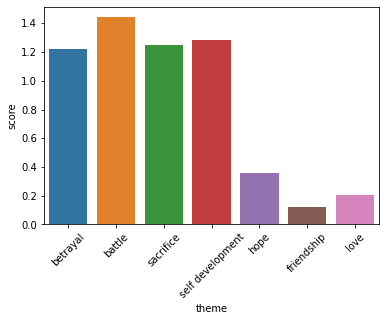

In [107]:
sns.barplot(data = theme_output ,x="theme",y="score" )
plt.xticks(rotation=45)
plt.show()